<h1>Importing Libraries</h1>

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Reading file and tidying

#### Reading csv file

In [2]:
df = pd.read_csv("loanprediction.csv")
df.drop("Id", axis=1, inplace=True)
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
numerical_cols = ["income", "age", "experience", "current_job_years", "current_house_years"]

#### Drop column(s)

In [3]:
#df.drop("Id", axis=1, inplace=True)
# df.drop("state", axis=1)
# df.drop("city", axis=1)

#### Renaming columns

In [4]:
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
df.head()

,income,age,experience,marital_status,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


#### Check the number of unique category for each categorical column

In [5]:
cat_cols = ["marital_status", "house_ownership", "car_ownership", "profession", "city", "state"]

# technology - Web_designer, Software_Developer, , Computer_operator, Technology_specialist
# medical - Physician, Microbiologist, Dentist, Surgeon, Psychologist
# analyst - Financial_Analyst, Analyst
# engineer - Computer_hardware_engineer, Industrial_Engineer, Mechanical_engineer, Chemical_engineer, Biomedical_Engineer, Petroleum_Engineer, Design_Engineer, Civil_engineer, Engineer, Technician
# aviation - Flight_attendant, Air_traffic_controller, Aviator
# government - Civil_servant, Official, Politician, Army_officer, Police_officer
# designer - Designer, Graphic_Designer, Fashion_Designer
# court - Magistrate, Lawyer
# architectural - Architect, Drafter


# 'Technical_writer',
# 'Librarian', 'Economist', 
# 'Artist', 'Surveyor', 
# 'Hotel_Manager', 'Comedian', 'Secretary', 
# 'Chartered_Accountant', 'Firefighter', 
# 'Geologist','Statistician', '
# 'Consultant', 'Chef', 'Scientist'

# Encoding categorical columns

#### Label encoding categorical columns with 2 types of categories

In [6]:
label_enc = LabelEncoder()
df["marital_status"] = label_enc.fit_transform(df["marital_status"])
df["car_ownership"] = label_enc.fit_transform(df["car_ownership"])

#### One Hot Encoding `house_ownership` column & Combining back to dataframe

In [7]:
onehot_enc = OneHotEncoder()
house_ownership_reshape = np.array(df["house_ownership"]).reshape(-1, 1)
house_ownership_values = onehot_enc.fit_transform(house_ownership_reshape).toarray().astype(int)
house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

df = df.join(house_ownership_df["norent_noown"])
df = df.join(house_ownership_df["owned"])
df = df.join(house_ownership_df["rented"])

df.drop("house_ownership", axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 14 columns):
income                 252000 non-null int64
age                    252000 non-null int64
experience             252000 non-null int64
marital_status         252000 non-null int32
car_ownership          252000 non-null int32
profession             252000 non-null object
city                   252000 non-null object
state                  252000 non-null object
current_job_years      252000 non-null int64
current_house_years    252000 non-null int64
risk_flag              252000 non-null int64
norent_noown           252000 non-null int32
owned                  252000 non-null int32
rented                 252000 non-null int32
dtypes: int32(5), int64(6), object(3)
memory usage: 22.1+ MB


#### Target Encoding the high cardinality categorical columns: `profession`, `city`, `state`

In [9]:
# https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64
target_enc = TargetEncoder()
df["profession_encoded"] = target_enc.fit_transform(df["profession"], df["risk_flag"])

In [10]:
target_enc = TargetEncoder()
df["city_encoded"] = target_enc.fit_transform(df["city"], df["risk_flag"])

In [11]:
target_enc = TargetEncoder()
df["state_encoded"] = target_enc.fit_transform(df["state"], df["risk_flag"])

df.drop("profession", axis=1, inplace=True)
df.drop("city", axis=1, inplace=True)
df.drop("state", axis=1, inplace=True)

#### Defining x and y (target) variables

In [12]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)
x.head()

,income,age,experience,marital_status,car_ownership,current_job_years,current_house_years,norent_noown,owned,rented,profession_encoded,city_encoded,state_encoded
0,1303834,23,3,1,0,3,13,0,0,1,0.111558,0.121554,0.154369
1,7574516,40,10,1,0,9,13,0,0,1,0.148427,0.122497,0.113254
2,3991815,66,4,0,0,4,10,0,0,1,0.134167,0.130814,0.167097
3,6256451,41,2,1,1,2,12,0,0,1,0.148427,0.326194,0.142550
4,5768871,47,11,1,0,3,14,0,0,1,0.115794,0.121137,0.103163


#### Perform Chi-Square for feature selection
H0 :- There is no relationship between categorical feature and target variable\
H1 :- There is some relationship between categorical feature and target variable\
If p-value ≥0.05, the null hypothesis is not rejected and there is no any relationship between target variable and categorical features.

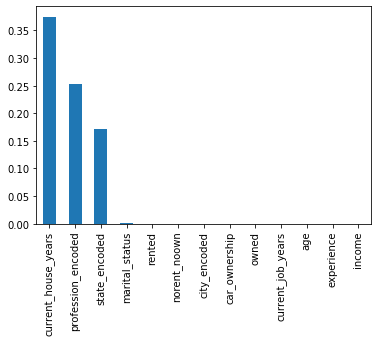

In [13]:
# https://medium.com/analytics-vidhya/categorical-feature-selection-using-chi-squared-test-e4c0d0af6b7e
# https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1

# Standardisation gives negative values, chi-square does not allow negative values

chi_scores = chi2(x,y)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

# # conclusion: current_house_years, profession_encoded, state_encoded have no relationship with target variable
x = x.drop(["current_house_years", "profession_encoded", "state_encoded"], axis=1)

#### Standardising columns

In [14]:
# # Scale all except columns which are one-hot encoded and label encoded

# # With Chi-Square
# to_scale = ["income", "age", "experience", "current_job_years", "city_encoded"]
# no_scale = ["marital_status", "car_ownership", "norent_noown", "owned", "rented"]

# # Without Chi-Square
# # to_scale = ["income", "age", "experience", "current_job_years", "current_house_years", "profession_encoded", "city_encoded", "state_encoded"]
# # no_scale = ["marital_status", "car_ownership", "norent_noown", "owned", "rented"]

# scaler = StandardScaler()
# scaled = scaler.fit_transform(x[to_scale])
# scaled_df = pd.DataFrame(data=scaled, columns=to_scale)

# for col in to_scale:
#     x[col] = scaled_df[col]
    
# x.head()

# Preparing for modelling

#### Splitting the dataset into train and test sets

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 69)

#### Performing PCA

In [16]:
# pca_loan = PCA()
# x_train = pca_loan.fit_transform(x_train)
# x_test = pca_loan.fit_transform(x_test)

#### Perform oversampling on train data

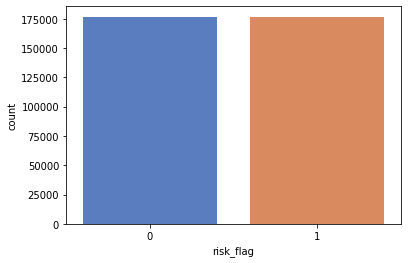

In [17]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

sns.countplot(x = y_train, palette = 'muted')

#### Applying xgboost model

In [31]:
dtree=tree.DecisionTreeClassifier()

In [32]:
param_dict = {
    "criterion":['gini','entropy'],
    "max_depth":range(1,10),
    "min_samples_split":range(2,10),
    "min_samples_leaf": [5,10,12,15]
}

In [34]:
grid = GridSearchCV(dtree,
                  param_grid=param_dict,
                  cv=10,
                  verbose=1,
                  n_jobs=-1,
                    scoring= 'recall')
grid.fit(x_train,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


C:\Users\thine\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354        nan 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
        nan 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354        nan 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
        nan 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354        nan 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
        nan 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354        nan 0.57888354 0.57888354
 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354 0.57888354
        nan 0.59850544 0.5985

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': [5, 10, 12, 15],
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [35]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 4}

In [18]:
# # # https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# xgb = XGBClassifier(learning_rate=0.1,
#                     n_estimators=1000,
#                     use_label_encoder=False,
#                     random_state=2021)

# xgb.fit(x_train, y_train, eval_metric='logloss')
# y_pred = xgb.predict(x_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

In [19]:
from sklearn import tree
depth = [3, 5, 8, 10]


In [20]:
dtree1 = tree.DecisionTreeClassifier(min_samples_leaf=12 ,random_state=69)

In [21]:
dtree1.fit(x_train, y_train)

DecisionTreeClassifier(min_samples_leaf=12, random_state=69)

In [22]:
n1_nodes = dtree1.tree_.node_count
print(n1_nodes)

14227


In [23]:
y_pred = dtree1.predict(x_test)

# print(cm)

In [24]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[38049  6188]
 [  802  5361]]


In [25]:
print("-------------------------TEST SCORES-----------------------")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

-------------------------TEST SCORES-----------------------
Recall: 0.8698685705013792
Precision: 0.464196034288683
F1-Score: 0.6053523035230353
Accuracy score: 0.8613095238095239
AUC Score: 0.8649928335247589


#### smoted , 10 levels
-------------------------TEST SCORES-----------------------\
Recall: 0.8466655849423982\
Precision: 0.4774453289413487\
F1-Score: 0.6105780482096888\
Accuracy score: 0.8679365079365079\
AUC Score: 0.8587827551721056\

#### smote 12 level
-------------------------TEST SCORES-----------------------\
Recall: 0.8481259127048515\
Precision: 0.4717934831663508\
F1-Score: 0.606310172833778\
Accuracy score: 0.8653174603174603\
AUC Score: 0.857919230512066\

#### smote 12 level chi sq
-------------------------TEST SCORES-----------------------\
Recall: 0.8650008112932014\
Precision: 0.46775467228217954\
F1-Score: 0.6071753986332574\
Accuracy score: 0.8631349206349206\
AUC Score: 0.8639378901053117\

#### smote 12 level chi sq with longjob
-------------------------TEST SCORES-----------------------\
Recall: 0.8650008112932014\
Precision: 0.4648587373561214\
F1-Score: 0.6047303045771653\
Accuracy score: 0.8617261904761905\
AUC Score: 0.8631353944568726\

#### smote 12 level chi sq with longjob and job val
-------------------------TEST SCORES-----------------------\
Recall: 0.8650008112932014\
Precision: 0.4648587373561214\
F1-Score: 0.6047303045771653\
Accuracy score: 0.8617261904761905\
AUC Score: 0.8631353944568726\

